In [1]:
#Generate time Axis
import numpy as np
samplingFrequency  = 500; # samplingTime = 0.002
timeAxis = np.linspace(0, samplingFrequency, samplingFrequency + 1) / samplingFrequency

In [2]:
gaussianSupport = 0.05
gaborMatrix = np.exp(- timeAxis**2 / gaussianSupport**2)

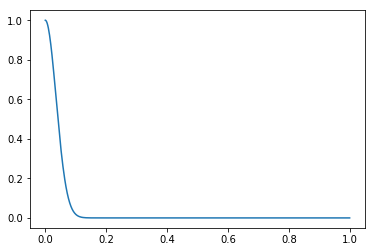

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(timeAxis, gaborMatrix)
plt.show()

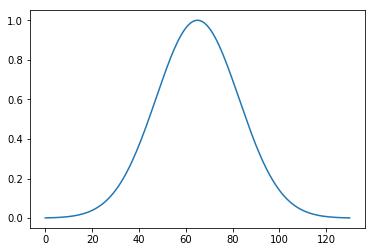

In [4]:
threshold = 0.001
nbNonZeros = sum(i >= threshold for i in gaborMatrix) - 1
supportIndexes = np.hstack((np.arange(nbNonZeros, -1, -1), np.arange(1, nbNonZeros + 1)))
gaborMatrix = gaborMatrix[supportIndexes]
plt.plot(gaborMatrix)
plt.show()

In [5]:
from scipy.sparse import csr_matrix
supportLength = gaborMatrix.size
timeAxisLength = timeAxis.size
timeAxisIndexes = np.arange(0, timeAxisLength, dtype = np.int16)
columnIndexes = np.repeat(timeAxisIndexes, supportLength);
gaborValues = np.tile(gaborMatrix, timeAxisLength)
atomIndexes = np.arange(0, supportLength, dtype = np.int16)
rowIndexes = np.tile(atomIndexes, timeAxisLength) + columnIndexes
nbRows = timeAxisLength + supportLength -1
gaborMatrix = csr_matrix((gaborValues, (rowIndexes, columnIndexes)), shape = (nbRows, timeAxisLength))

In [6]:
print (gaborMatrix.shape)
gaborMatrix = gaborMatrix[nbNonZeros: (nbNonZeros + timeAxisLength), :]
print (gaborMatrix.shape)

(631, 501)
(501, 501)


In [7]:
#sine/cosine basis
import numpy as np
nbFrequencies = 30
freqFactors = np.arange(1, nbFrequencies + 1)
freqFactors = np.repeat(freqFactors, 2)
freqFactors = np.insert(freqFactors, 0, 0)
print (freqFactors)
print (freqFactors.shape)

[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24
 24 25 25 26 26 27 27 28 28 29 29 30 30]
(61,)


In [8]:
phases = np.tile(np.array([0.0, -(0.5 * np.pi)]), nbFrequencies) #to switch between sine and cosine
phases = np.insert(phases, 0, 0)
print (phases)
print (phases.shape)

[ 0.          0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633  0.         -1.57079633  0.         -1.57079633  0.
 -1.57079633]
(61,)


In [9]:
#making the matrix of sinusoids (nbTimeSamples * nbSinusoids)
baseFrequecy = 5;     # base * nbWavelets = 150 for good results (is it related with nyquist frequency)
nbSinusoids = 2 * nbFrequencies + 1

sinusoidValues = np.zeros(timeAxisLength * nbSinusoids)
offset = 0;
for i in range(nbSinusoids):
    frequency = freqFactors[i] * baseFrequecy
    phase = phases[i]
    for j in range(timeAxisLength):
        sinusoidValues[offset] = np.cos(frequency * timeAxis[j] + phase)
        offset += 1

(30561,)


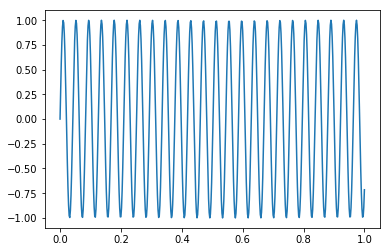

In [10]:
print (sinusoidValues.shape)
sinusoidIdx = 60
plt.plot(timeAxis, sinusoidValues[sinusoidIdx * timeAxisLength: (sinusoidIdx + 1) * timeAxisLength])
plt.show()

In [11]:
rowIndexes = np.arange(0, timeAxisLength * nbSinusoids)
print (rowIndexes.shape)
columnIndexes = np.remainder(rowIndexes, timeAxisLength)
print (columnIndexes.shape)

(30561,)
(30561,)


In [12]:
dictionary = csr_matrix((sinusoidValues, (rowIndexes, columnIndexes)), shape = (offset, timeAxisLength))
print (dictionary.shape)
print (dictionary.nnz)

(30561, 501)
30561


In [13]:
sinusoidIdx = 30;
print (dictionary[sinusoidIdx * timeAxisLength: (sinusoidIdx + 1) * timeAxisLength, :].nnz)

501


In [14]:
dictionary = dictionary * gaborMatrix
#print (gaborMatrix.shape)

In [15]:
print (dictionary.shape)

(30561, 501)


In [16]:
sinusoidIdx = 0;
print (dictionary[sinusoidIdx * timeAxisLength: (sinusoidIdx + 1) * timeAxisLength, :].nnz)

61341


In [17]:
from auxiliar import reshape
newShape = (timeAxisLength, offset)
dictionary = reshape(dictionary, newShape)

In [18]:
print (dictionary.shape)
sinusoidIdx = 0;
print (dictionary[:, sinusoidIdx * timeAxisLength: (sinusoidIdx + 1) * timeAxisLength].nnz)

(501, 30561)
34878
